In [1]:
from pathlib import Path

from tqdm.auto import tqdm

import numpy as np

from specutils import Spectrum1D

import torch

from matplotlib import pyplot as plt

from astropy.visualization import quantity_support
quantity_support()

from astropy import units as u
from astropy.modeling import models, fitting

In [2]:
spec_tensors = [torch.load(p, weights_only=True) for p in Path('resampled_tensors').glob('*_2k.pt')]
len(spec_tensors)

7508

In [3]:
specs = [Spectrum1D(flux=tens['flux'].numpy() << u.Unit(tens['header']['BUNIT']), spectral_axis=tens['wl'].numpy()*u.angstrom, meta=tens['header']) for tens in spec_tensors]
len(specs)

7508

<WCSAxes: ylabel='Data [erg / (s cm3)]'>

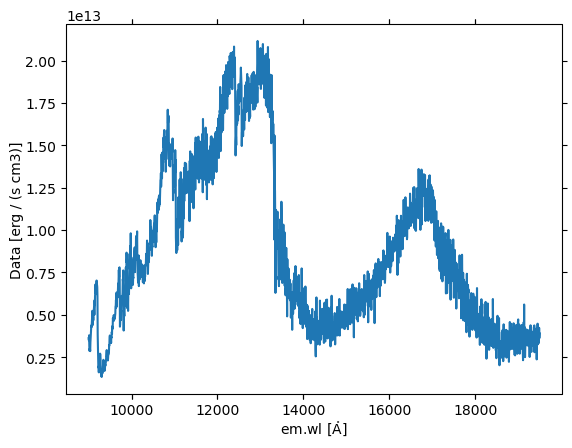

In [21]:
specs[0].plot()

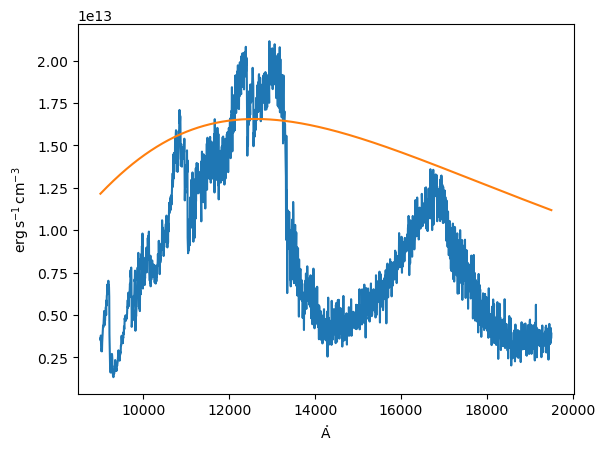

In [105]:
bb = models.BlackBody(temperature=specs[0].meta['PHXTEFF']*u.K, scale=1*specs[0].flux.unit/u.sr)
plt.plot(specs[0].wavelength, specs[0].flux)
plt.plot(specs[0].wavelength, bb(specs[0].wavelength)*(4*np.pi*u.sr)/2) # only outward-going for the /2

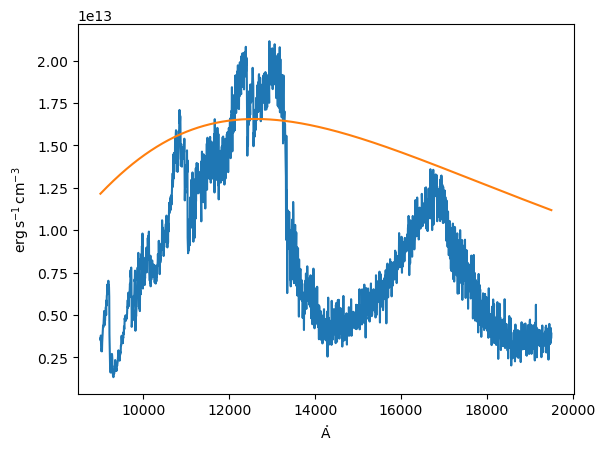

In [14]:
bb = models.BlackBody(temperature=specs[0].meta['PHXTEFF']*u.K, scale=1*specs[0].flux.unit/u.sr)
plt.plot(specs[0].wavelength, specs[0].flux)
plt.plot(specs[0].wavelength, bb(specs[0].wavelength)*(4*np.pi*u.sr)/2) # only outward-going for the /2

In [4]:
bb_arrays = []
for spec in tqdm(specs):
    bb = models.BlackBody(temperature=spec.meta['PHXTEFF']*u.K, scale=1*spec.flux.unit/u.sr)
    bbarr = bb(spec.wavelength)
    bbarrconv = (bbarr*(4*np.pi*u.sr)/2).to(spec.flux.unit)
    bb_arrays.append(bbarrconv)

bb_arrays = u.Quantity(bb_arrays)
bb_arrays.shape

  0%|          | 0/7508 [00:00<?, ?it/s]

(7508, 2048)

In [5]:
residuals = u.Quantity([s.flux for s in specs]) - bb_arrays

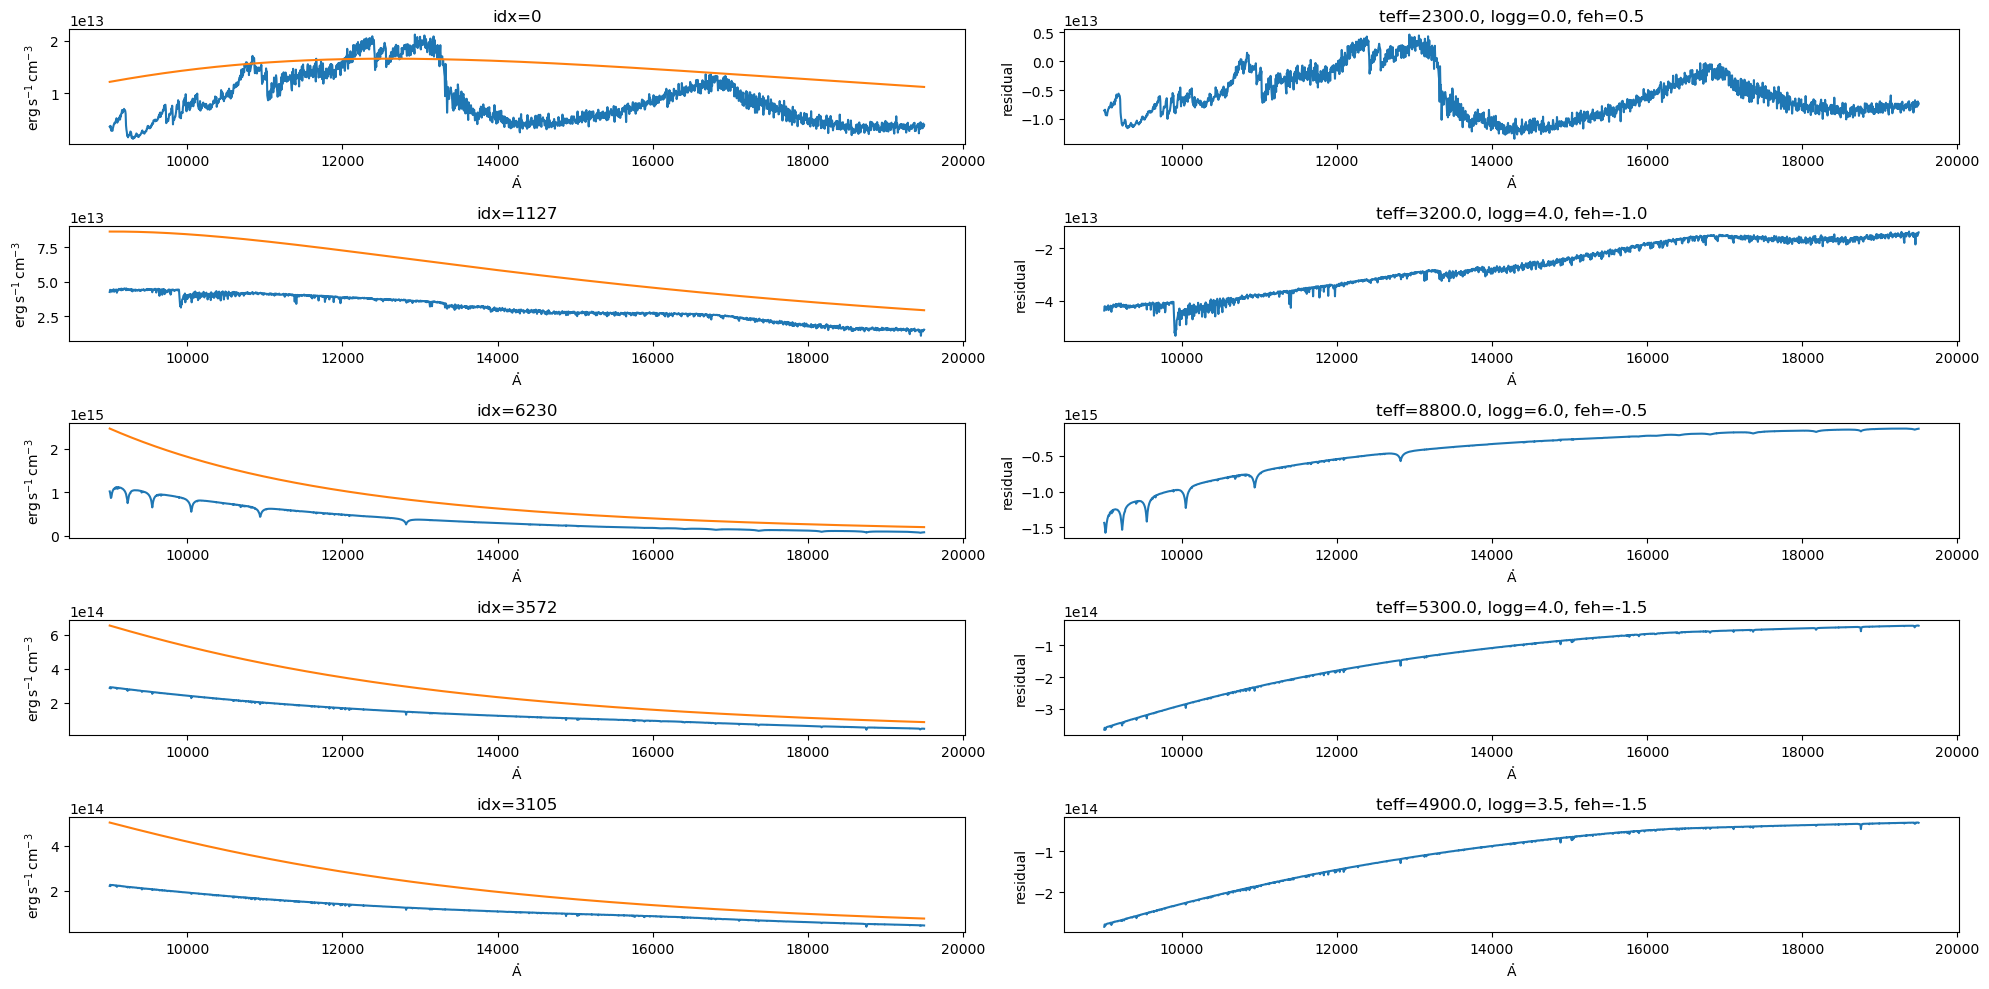

In [6]:
n = 5
idxs = np.random.permutation(len(specs))[:n]
idxs[0] = 0

fig, axs = plt.subplots(n, 2, figsize=(20, 10))
for (ax1, ax2), idx in zip(axs, idxs):
    spec = specs[idx]
    ax1.plot(spec.wavelength, spec.flux, label='realflux')
    ax1.plot(spec.wavelength, bb_arrays[idx], label='bbmodel')
    
    ax2.plot(spec.wavelength, residuals[idx])

    ax1.set_title(f'idx={idx}')
    
    hdr = spec.meta
    ax2.set_title(f"teff={hdr['PHXTEFF']}, logg={hdr['PHXLOGG']}, feh={hdr['PHXM_H']}")
    ax2.set_ylabel('residual')

fig.tight_layout()

Ugh atmospheres are not actually one temperature...what about mean-inating?

In [29]:
(sflux.T-np.mean(sflux,axis=1))/np.std(sflux,axis=1)

<Quantity [[-1.05929679, -0.17706081, -1.07477779, ...,  2.30138515,
             2.29655518,  2.29581647],
           [-1.08429062, -0.10130789, -1.10519178, ...,  2.15637489,
             2.1504264 ,  2.14953986],
           [-1.0248582 , -0.14466292, -1.02725698, ...,  1.99090096,
             1.98369967,  1.98254537],
           ...,
           [-0.93493379, -1.65562425, -1.01435591, ..., -1.00335664,
            -1.00402374, -1.00416712],
           [-1.05991084, -1.7708653 , -1.16224759, ..., -1.00138561,
            -1.00202266, -1.00215949],
           [-1.00182629, -1.6865759 , -1.07847537, ..., -0.99959168,
            -1.00020078, -1.00033203]]>

In [32]:
sflux = u.Quantity([s.flux for s in specs])
stdresiduals = ((sflux.T-np.mean(sflux,axis=1))/np.std(sflux,axis=1) - (bb_arrays.T-np.mean(bb_arrays,axis=1))/np.std(bb_arrays,axis=1)).T
stdresiduals.shape

(7508, 2048)

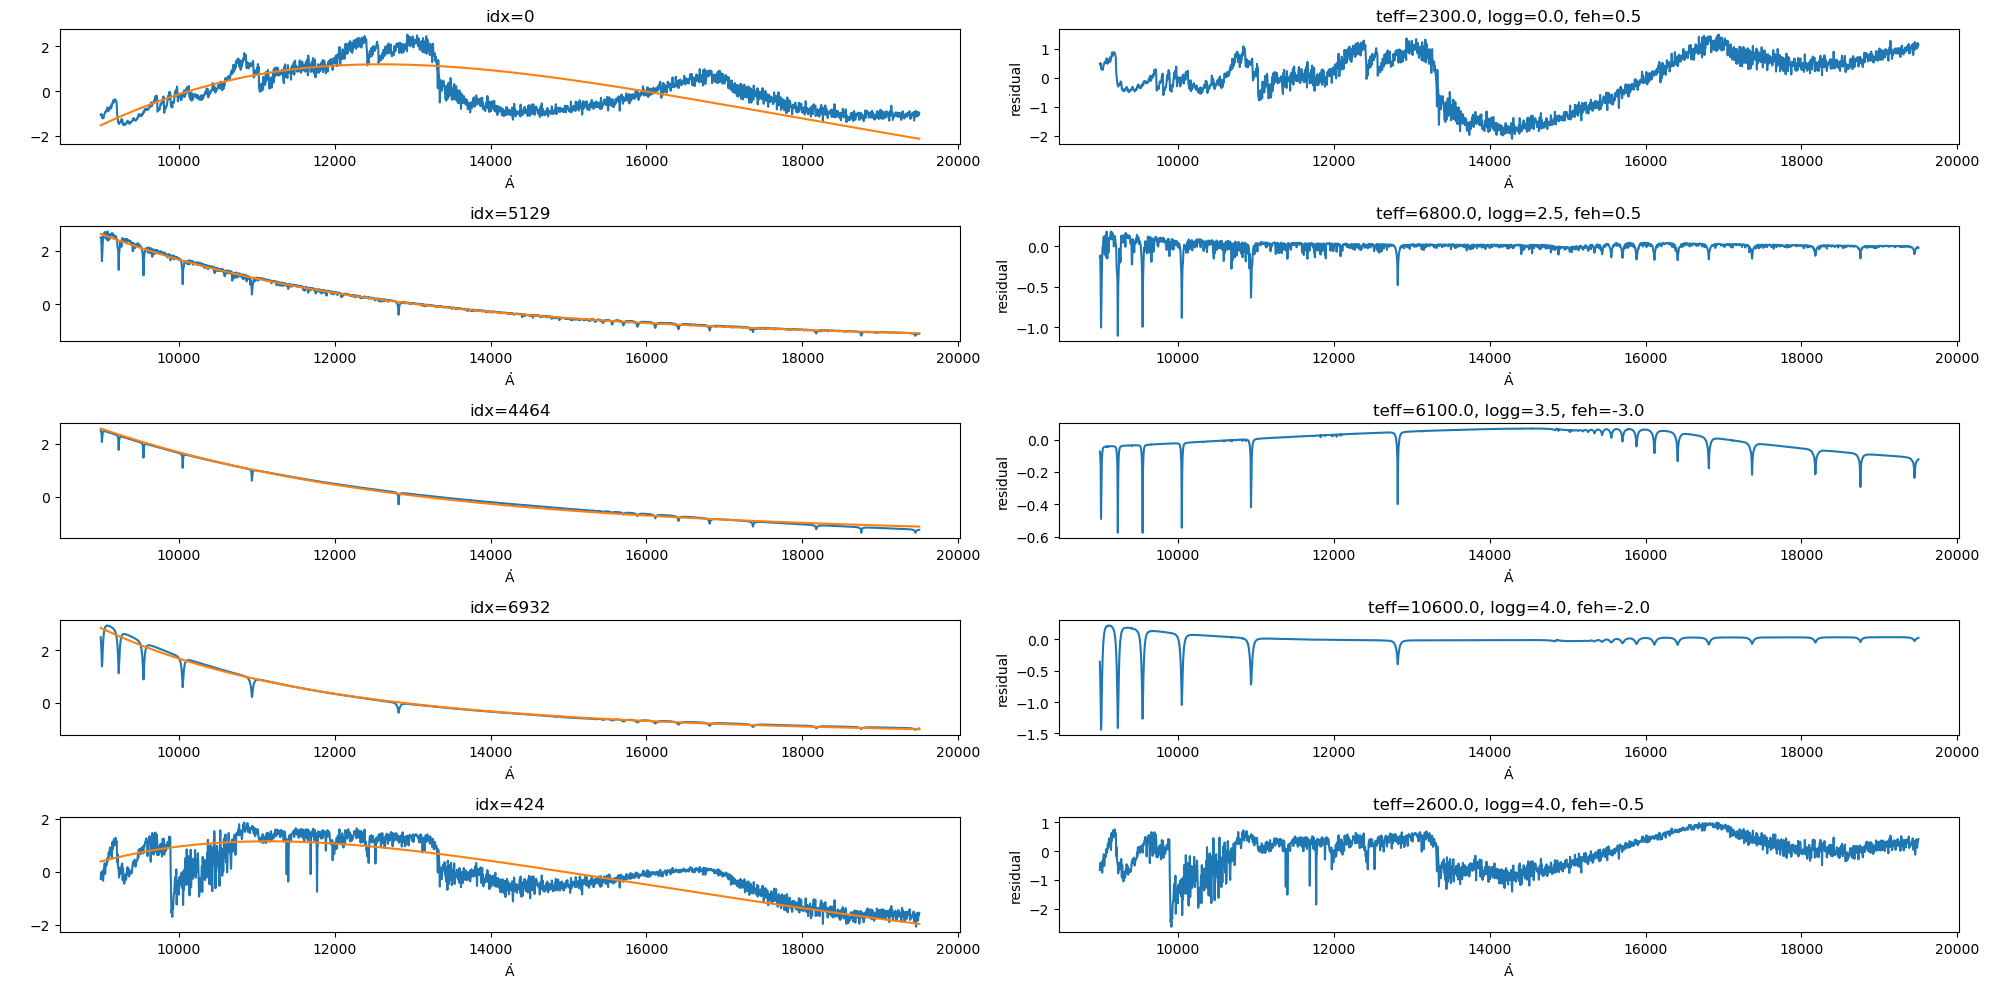

In [33]:
n = 5
idxs = np.random.permutation(len(specs))[:n]
idxs[0] = 0

fig, axs = plt.subplots(n, 2, figsize=(20, 10))
for (ax1, ax2), idx in zip(axs, idxs):
    spec = specs[idx]
    ax1.plot(spec.wavelength, (spec.flux - spec.flux.mean())/spec.flux.std(), label='realflux')
    ax1.plot(spec.wavelength, (bb_arrays[idx] - bb_arrays[idx].mean())/bb_arrays[idx].std(), label='bbmodel')
    
    ax2.plot(spec.wavelength, stdresiduals[idx])

    ax1.set_title(f'idx={idx}')
    
    hdr = spec.meta
    ax2.set_title(f"teff={hdr['PHXTEFF']}, logg={hdr['PHXLOGG']}, feh={hdr['PHXM_H']}")
    ax2.set_ylabel('residual')

fig.tight_layout()

Hmm, that doesn't really do us much good because it requires knowing the mean to get back the real spectrum, but maybe it will still make learning easier? Lets just see how it varies across the parameters.

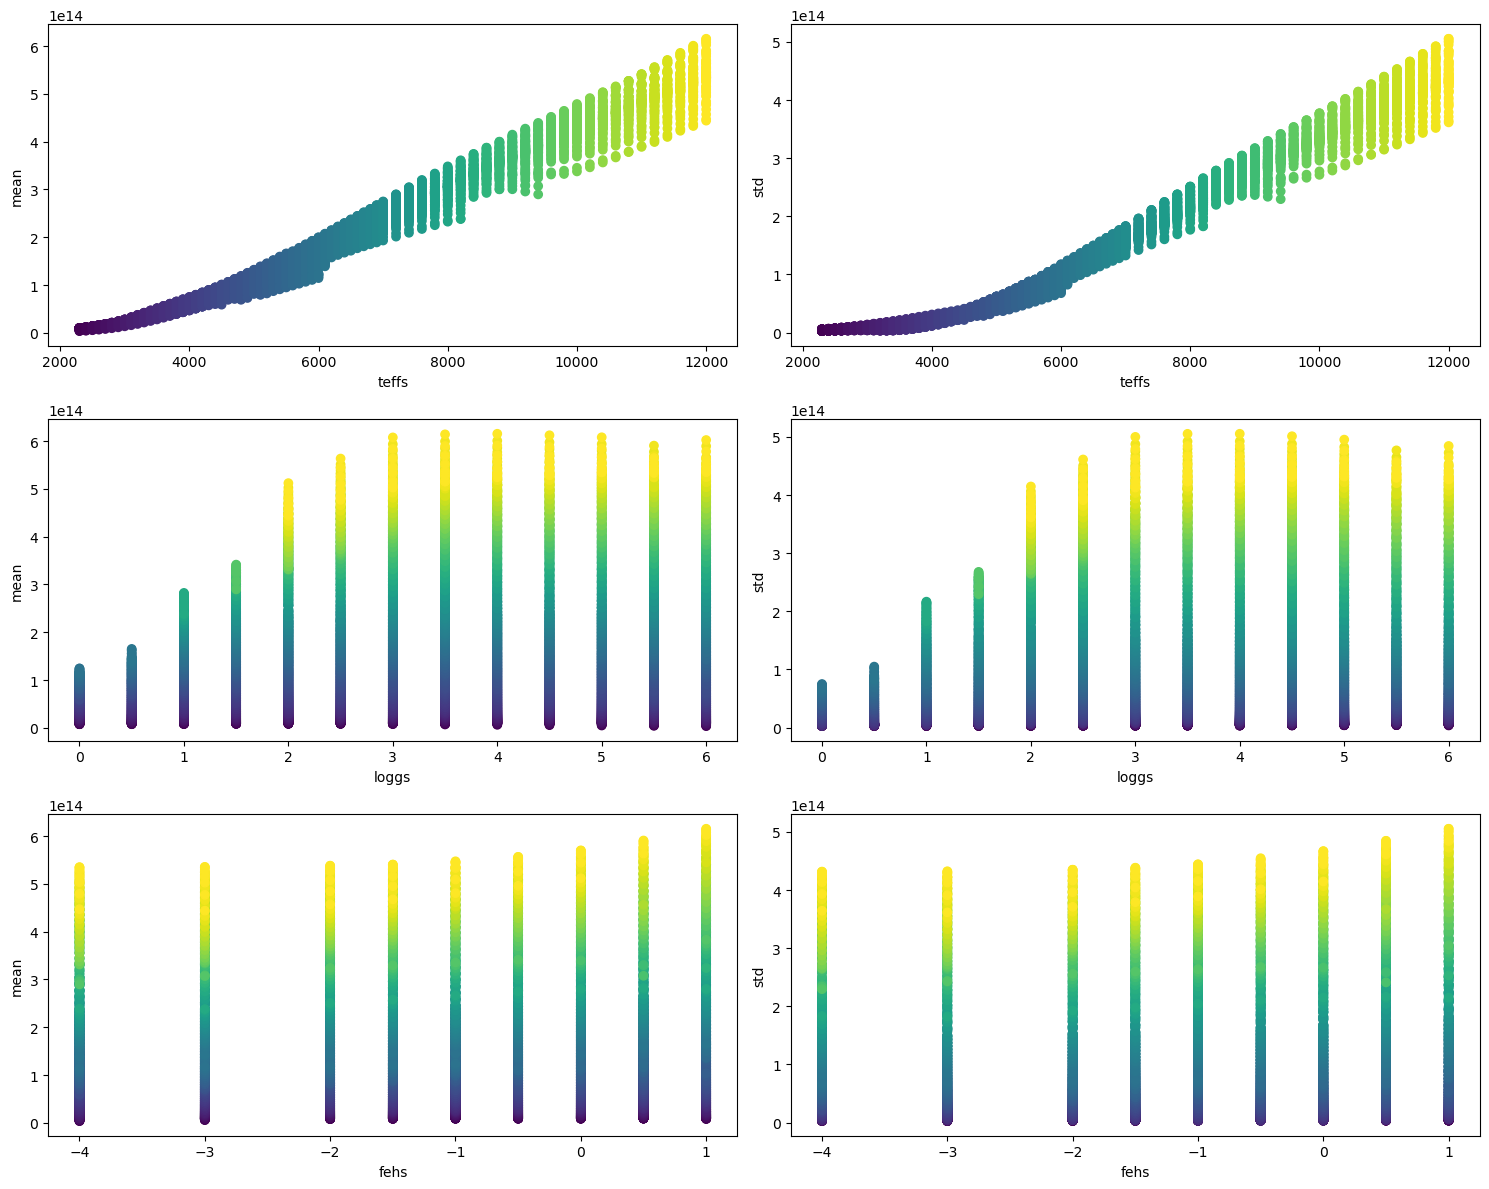

In [56]:
means = [spec.flux.mean() for spec in specs]
stds = [spec.flux.std() for spec in specs]
teffs = [spec.meta['PHXTEFF'] for spec in specs]
loggs = [spec.meta['PHXLOGG'] for spec in specs]
fehs = [spec.meta['PHXM_H'] for spec in specs]

fig, axs = plt.subplots(3, 2, figsize=(15, 12))
for (ax1, ax2), xnm in zip(axs, 'teffs,loggs,fehs'.split(',')):
    x = globals()[xnm]

    ax1.scatter(x, means, c=teffs)
    ax1.set_ylabel('mean')
    ax2.scatter(x, stds, c=teffs)
    ax2.set_ylabel('std')

    ax1.set_xlabel(xnm)
    ax2.set_xlabel(xnm)

fig.tight_layout()

Pretty close to a clean function of teff so might be good enough to fit that if the meaninating makes a big difference.

How does mean evolve?

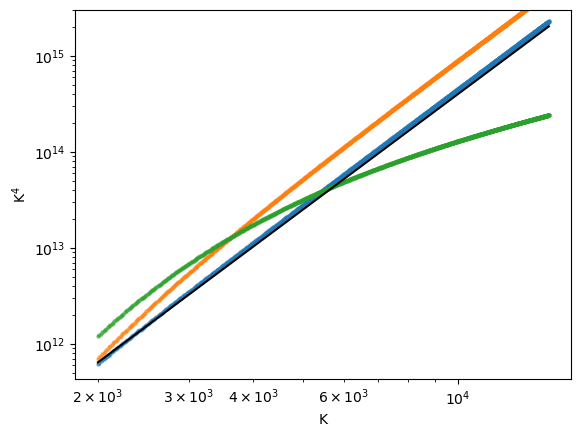

In [59]:
ts = np.linspace(2000,15000,1024)*u.K

wl = np.linspace(100,40000, 10000)*u.angstrom
ms =[]
for t in ts:
    bb = models.BlackBody(t, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    f = bb(wl)
    ms.append(f.mean().value)

wl2 = np.linspace(100, 20000, 10000)*u.angstrom
ms2 =[]
for t in ts:
    bb = models.BlackBody(t, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    f = bb(wl2)
    ms2.append(f.mean().value)


wl3 = np.linspace(10000, 20000, 10000)*u.angstrom
ms3 =[]
for t in ts:
    bb = models.BlackBody(t, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    f = bb(wl3)
    ms3.append(f.mean().value)

plt.scatter(ts, ms,  s=5, alpha=.5)
plt.scatter(ts, ms2, s=5, alpha=.5)
plt.scatter(ts, ms3, s=5, alpha=.5)
plt.loglog(ts, 4e-2*ts**4, c='k')